# [E-09] Pneumonia Detection
"Exploration Node 9. Let's beat out pneumonia" / 2022. 02. 10 (Thu) 이형주

## Contents
---
- **최초 이미지 및 모델링 준비 - 미국 전 대통령 도널드 트럼프님**
- **얼굴 감지**
- **얼굴 이목구비 위치 탐색**
- **스티커 위치좌표 설정 및 조정**
- **다양한 케이스에 적용하기**
    - **Case1: 얼굴이 멀리 떨어진 경우 - 정치인 허경영님**
    - **Case2: 얼굴이 큰 경우 - 스타크래프트 프로게이머 홍구님**
    - **Case3: 얼굴 각도가 틀어진 경우 - 배우 진세연님**
- **프로젝트 회고**


## Rubric Evaluation Standards
---

|  평가문항  |  상세기준  |
|:---------|:---------|
|1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.|모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.
|2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.|regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.
|3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.|Accuracy 기준 85%에 도달하였다.


## 1. Model and Data Preparations

In [61]:
import re    # 정규표현식 관련된 작업에 필요한 패키지
import os    # I/O 관련된 작업에 필요한 패키지 
import pandas as pd     # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np      # 데이터 array 작업에 필요한 패키지
import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지
import random, math
import warnings 
warnings.filterwarnings(action='ignore')


# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'


BATCH_SIZE = 16
EPOCHS = 6

print(ROOT_PATH)


train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))


# train 데이터와 validation 데이터를 모두 filenames로
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))

print(len(val_filenames))

/aiffel/aiffel
5216
624
16
4185
1047


In [5]:
# 정상, 폐렴 이미지 수 확인
COUNT_NORMAL = len([filename for filename in train_filenames if 'NORMAL' in filename])
print('Normal images count in training set :', str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if 'PNEUMONIA' in filename])
print('Pneumonia images count in training set :', str(COUNT_PNEUMONIA))

# 배치처리 효율화를 위한 tf.data 인스턴스 생성
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

# 데이터 라벨링 (폐렴 여부에 따라 판단)
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

# 이미지를 알맞은 형식으로 변환
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력 -> 이미지와 라벨 로딩
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

for image, label in train_ds.take(1): # 데이터 하나만 불러옴
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Normal images count in training set : 1070
Pneumonia images count in training set : 3115
Training images count: 4185
Validating images count: 1047
Image shape:  (180, 180, 3)
Label:  False


In [6]:
# test 데이터셋 및 데이터 갯수

test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)


def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE) #학습 데이터를 나눠서 로드 -> 효율성 증대
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

624


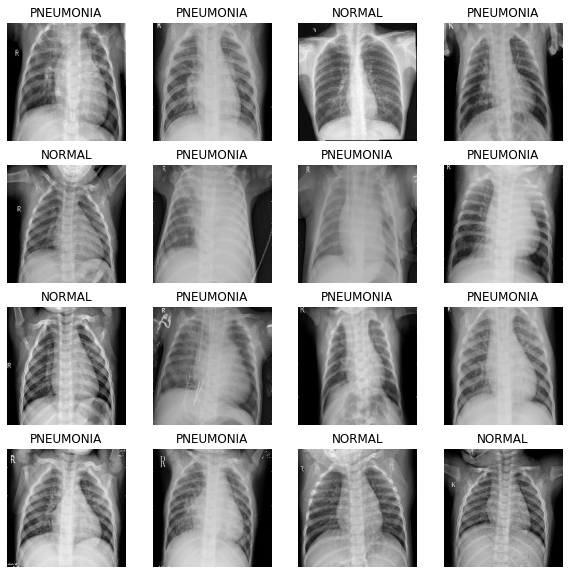

In [7]:
# 데이터 시각화
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## 2. CNN Modeling & Training

+ convolution block, dense block으로 나눠 설계
+ batch normalization, dropout 동시 사용 X, batch normalization만 사용
    - 두 개를 동시에 사용하는 것에 대한 찬/반 양론이 있음
        - [동시사용 찬성](https://arxiv.org/pdf/1905.05928.pdf)
        - [동시사용 반대](https://openaccess.thecvf.com/content_CVPR_2019/papers/Li_Understanding_the_Disharmony_Between_Dropout_and_Batch_Normalization_by_Variance_CVPR_2019_paper.pdf)
    - 결론적으로 CNN 모델링에서는 Dropout ratio를 0.5 미만으로 하였을 시에만 제한적으로 사용 가능하나 근본적으로 Batch Normalization 동시 사용은 반대 논문에서 권장하지 않고 있다. 또한 논문에서 사용된 DataSet 실험 갯수가 2개로 제한적인 관계로 Dropout 비율을 0.1로 극도로 제한한 값과 동시 사용하였을 때의 값을 비교하기로 방향성을 결정하였다.
        - In modern CNN architectures, the original Dropout and BN are not recommended to appear in the bottleneck part due to their variance shift conflict, except that we have a relatively large feature dimension. We also suggest the drop ratio < 0.5 since the deduction Eq. (12) and the experiments (Fig. 4) show higher drop ratio will still break the stability of neural responses in any case. To conclude, the shift risk depends on both the Dropout ratio and feature dimension. (반대논문 내용 발췌)

In [8]:
# convolution block
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [9]:
# dense block
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [10]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.1), #0.1
        
        conv_block(256),
        tf.keras.layers.Dropout(0.1), #0.1
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [11]:
#Weight Balancing

weight_for_0 = (1/COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1/COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0:weight_for_0, 1:weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.96
Weight for class 1: 0.67


In [12]:
with tf.device('/GPU:0'):
    model = build_model()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS)

In [13]:
# training
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 88s 192ms/step - loss: 0.4060 - accuracy: 0.8118 - precision: 0.9528 - recall: 0.7861 - val_loss: 0.7689 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 49s 188ms/step - loss: 0.2344 - accuracy: 0.9136 - precision: 0.9771 - recall: 0.9050 - val_loss: 1.1656 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 49s 187ms/step - loss: 0.2043 - accuracy: 0.9243 - precision: 0.9758 - recall: 0.9212 - val_loss: 0.9152 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 50s 192ms/step - loss: 0.1882 - accuracy: 0.9260 - precision: 0.9746 - recall: 0.9247 - val_loss: 0.0801 - val_accuracy: 0.9760 - val_precision: 0.9804 - val_recall: 0.9869
Epoch 5/25
261/261 [==============================] - 51s 197ms/step - loss: 0.1597 - accura

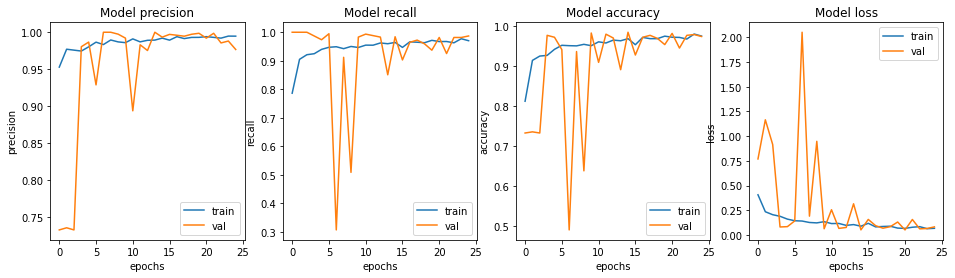

In [14]:
# result visualization (Dropout + Batch Normalization)
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_'+met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [15]:
loss, acc, prec, rec = model.evaluate(test_ds)
# model accuracy 74.6%

39/39 [==============================] - 4s 103ms/step - loss: 1.4572 - accuracy: 0.7468 - precision: 0.7140 - recall: 0.9923


## 3. Performance Improvements

**Batch Normalization만 사용**

In [16]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        #tf.keras.layers.Dropout(dropout_rate)    # dropout 제거
    ])
    return block

In [21]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),    
        conv_block(128),
        conv_block(256),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [23]:
with tf.device('/GPU:0'):
    model = build_model()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS)

In [25]:
# training
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 57s 185ms/step - loss: 0.2462 - accuracy: 0.9037 - precision: 0.9754 - recall: 0.8931 - val_loss: 0.6126 - val_accuracy: 0.7317 - val_precision: 0.7317 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 48s 184ms/step - loss: 0.1612 - accuracy: 0.9346 - precision: 0.9810 - recall: 0.9303 - val_loss: 1.1512 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 48s 185ms/step - loss: 0.1153 - accuracy: 0.9545 - precision: 0.9886 - recall: 0.9498 - val_loss: 0.3182 - val_accuracy: 0.8154 - val_precision: 0.7990 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 49s 187ms/step - loss: 0.1264 - accuracy: 0.9559 - precision: 0.9876 - recall: 0.9526 - val_loss: 0.1286 - val_accuracy: 0.9596 - val_precision: 0.9959 - val_recall: 0.9489
Epoch 5/25
261/261 [==============================] - 49s 189ms/step - loss: 0.0953 - accura

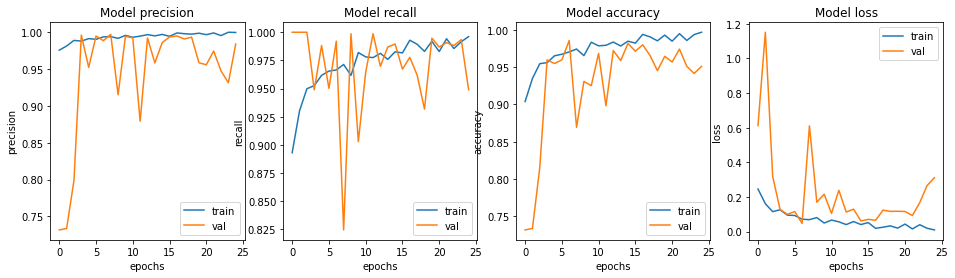

In [26]:
# result visualization (Batch Normalization)
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_'+met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [27]:
loss, acc, prec, rec = model.evaluate(test_ds)
#model accuracy: 78.37%

39/39 [==============================] - 4s 105ms/step - loss: 3.7429 - accuracy: 0.7837 - precision: 0.7495 - recall: 0.9821


+ Model Accuracy가 소폭 증가하는데 그쳤다. 그리고 Epoch은 8회 이내로 Early Stopping 하는게 좋을 것 같다.

**Batch Normalization, Dropout 제거**

In [29]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

In [30]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        #tf.keras.layers.BatchNormalization(),    # batch normalization 제거
        #tf.keras.layers.Dropout(dropout_rate)    # dropout 제거
    ])
    return block

In [31]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),    
        conv_block(128),
        conv_block(256),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [32]:
with tf.device('/GPU:0'):
    model = build_model()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS)

In [33]:
# training
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,callbacks=[es]
    )

Epoch 1/25
261/261 [==============================] - 57s 187ms/step - loss: 0.2312 - accuracy: 0.8922 - precision: 0.9743 - recall: 0.8783 - val_loss: 1.0959 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 48s 183ms/step - loss: 0.1275 - accuracy: 0.9547 - precision: 0.9857 - recall: 0.9530 - val_loss: 0.8518 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 47s 182ms/step - loss: 0.0913 - accuracy: 0.9598 - precision: 0.9923 - recall: 0.9534 - val_loss: 0.1043 - val_accuracy: 0.9635 - val_precision: 0.9665 - val_recall: 0.9842
Epoch 4/25
261/261 [==============================] - 48s 183ms/step - loss: 0.0861 - accuracy: 0.9638 - precision: 0.9936 - recall: 0.9575 - val_loss: 0.5677 - val_accuracy: 0.9135 - val_precision: 0.8955 - val_recall: 0.9987
Epoch 5/25
261/261 [==============================] - 49s 187ms/step - loss: 0.0917 - accura

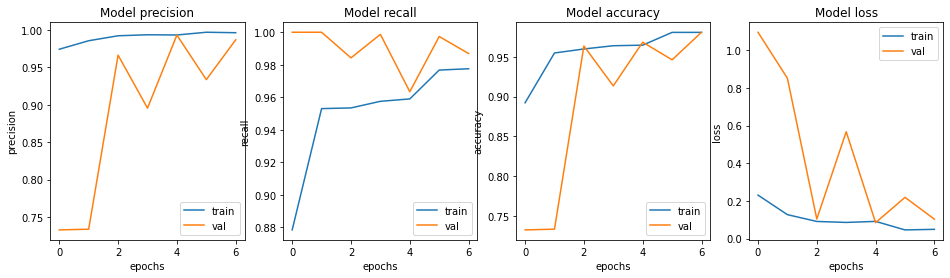

In [34]:
# result visualization (Batch Normalization)
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_'+met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [36]:
loss, acc, prec, rec = model.evaluate(test_ds)
#model accuracy: 78.37%

39/39 [==============================] - 4s 108ms/step - loss: 2.1995 - accuracy: 0.7837 - precision: 0.7457 - recall: 0.9923


+ Accuracy에 차이가 없다. Dropout만 사용하면 어떨까?

**Dropout만 사용**

In [37]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        #tf.keras.layers.BatchNormalization(), # batch normalization 제거
        tf.keras.layers.Dropout(dropout_rate)    
    ])
    return block

In [38]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),    
        conv_block(128),
        tf.keras.layers.Dropout(0.1), #0.1
        
        conv_block(256),
        tf.keras.layers.Dropout(0.1), #0.1
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [39]:
with tf.device('/GPU:0'):
    model = build_model()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS)

In [40]:
# training
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,callbacks=[es]
    )

Epoch 1/25
261/261 [==============================] - 57s 185ms/step - loss: 0.3533 - accuracy: 0.8343 - precision: 0.9371 - recall: 0.8334 - val_loss: 0.6443 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 48s 184ms/step - loss: 0.2415 - accuracy: 0.9018 - precision: 0.9760 - recall: 0.8899 - val_loss: 4.1525 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 49s 186ms/step - loss: 0.2025 - accuracy: 0.9157 - precision: 0.9781 - recall: 0.9070 - val_loss: 0.2740 - val_accuracy: 0.8615 - val_precision: 0.8416 - val_recall: 0.9987
Epoch 4/25
261/261 [==============================] - 48s 186ms/step - loss: 0.1576 - accuracy: 0.9337 - precision: 0.9803 - recall: 0.9296 - val_loss: 0.2617 - val_accuracy: 0.9260 - val_precision: 0.9113 - val_recall: 0.9961
Epoch 5/25
261/261 [==============================] - 48s 186ms/step - loss: 0.1486 - accura

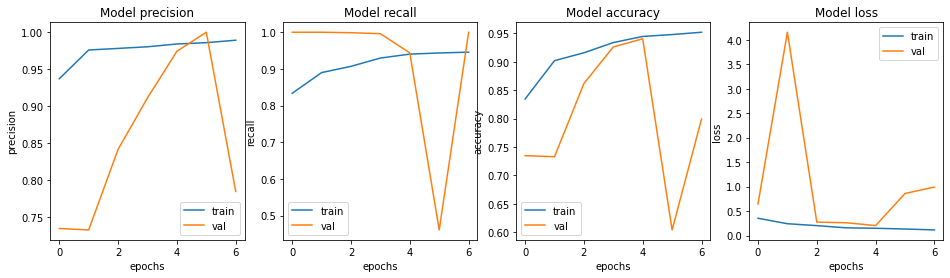

In [41]:
# result visualization (Dropout)
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_'+met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [42]:
loss, acc, prec, rec = model.evaluate(test_ds)
# model accuracy: 63.30%

39/39 [==============================] - 4s 105ms/step - loss: 5.4267 - accuracy: 0.6330 - precision: 0.6300 - recall: 1.0000


+ Model Accuracy가 가장 높은, Epoch 4회로 조정하여 재시도

In [43]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        #tf.keras.layers.BatchNormalization(), # batch normalization 제거
        tf.keras.layers.Dropout(dropout_rate)    
    ])
    return block

In [44]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),    
        conv_block(128),
        tf.keras.layers.Dropout(0.1), #0.1
        
        conv_block(256),
        tf.keras.layers.Dropout(0.1), #0.1
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [45]:
with tf.device('/GPU:0'):
    model = build_model()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS)

In [51]:
# training
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight
    )

Epoch 1/4
261/261 [==============================] - 56s 187ms/step - loss: 0.3683 - accuracy: 0.8338 - precision: 0.9494 - recall: 0.8205 - val_loss: 0.5855 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/4
261/261 [==============================] - 48s 186ms/step - loss: 0.2015 - accuracy: 0.9188 - precision: 0.9826 - recall: 0.9070 - val_loss: 1.4016 - val_accuracy: 0.7317 - val_precision: 0.7317 - val_recall: 1.0000
Epoch 3/4
261/261 [==============================] - 48s 186ms/step - loss: 0.1602 - accuracy: 0.9368 - precision: 0.9843 - recall: 0.9299 - val_loss: 1.9812 - val_accuracy: 0.7481 - val_precision: 0.7451 - val_recall: 1.0000
Epoch 4/4
261/261 [==============================] - 49s 187ms/step - loss: 0.1409 - accuracy: 0.9437 - precision: 0.9819 - recall: 0.9419 - val_loss: 0.1234 - val_accuracy: 0.9442 - val_precision: 0.9944 - val_recall: 0.9293


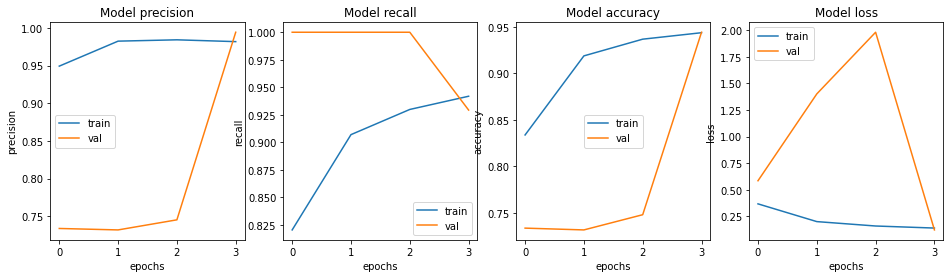

In [52]:
# result visualization (Dropout)
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_'+met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [53]:
loss, acc, prec, rec = model.evaluate(test_ds)
# Accuracy: 83.49%

39/39 [==============================] - 4s 110ms/step - loss: 0.4977 - accuracy: 0.8349 - precision: 0.8154 - recall: 0.9513


+ Data Augmentation까지 진행하면?

**Dropout + Data Augmentation**

In [54]:
# Dropout + Data Augmentation

def augment(image, label):
    image = tf.image.random_flip_left_right(image) # 랜덤 좌우반전
    return image, label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.map(augment, num_parallel_calls=2) # data augmentation 과정 추가
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    return ds

train_ds_a = prepare_for_training(train_ds)
val_ds_a = prepare_for_training(val_ds)

print(train_ds_a)

<PrefetchDataset shapes: ((None, None, 180, 180, 3), (None, None)), types: (tf.float32, tf.bool)>


In [55]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        #tf.keras.layers.BatchNormalization(), # batch normalization 제거
        tf.keras.layers.Dropout(dropout_rate)    
    ])
    return block

In [56]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),    
        conv_block(128),
        tf.keras.layers.Dropout(0.1), #0.1
        
        conv_block(256),
        tf.keras.layers.Dropout(0.1), #0.1
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [57]:
with tf.device('/GPU:0'):
    model = build_model()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS)

In [58]:
# training
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight
    )

Epoch 1/4
261/261 [==============================] - 58s 190ms/step - loss: 0.3206 - accuracy: 0.8300 - precision: 0.9666 - recall: 0.7994 - val_loss: 1.5743 - val_accuracy: 0.7317 - val_precision: 0.7317 - val_recall: 1.0000
Epoch 2/4
261/261 [==============================] - 49s 187ms/step - loss: 0.1814 - accuracy: 0.9272 - precision: 0.9811 - recall: 0.9199 - val_loss: 4.8753 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/4
261/261 [==============================] - 49s 188ms/step - loss: 0.1518 - accuracy: 0.9447 - precision: 0.9855 - recall: 0.9396 - val_loss: 0.1420 - val_accuracy: 0.9433 - val_precision: 0.9916 - val_recall: 0.9305
Epoch 4/4
261/261 [==============================] - 49s 188ms/step - loss: 0.1270 - accuracy: 0.9514 - precision: 0.9872 - recall: 0.9468 - val_loss: 0.4186 - val_accuracy: 0.8712 - val_precision: 0.8506 - val_recall: 1.0000


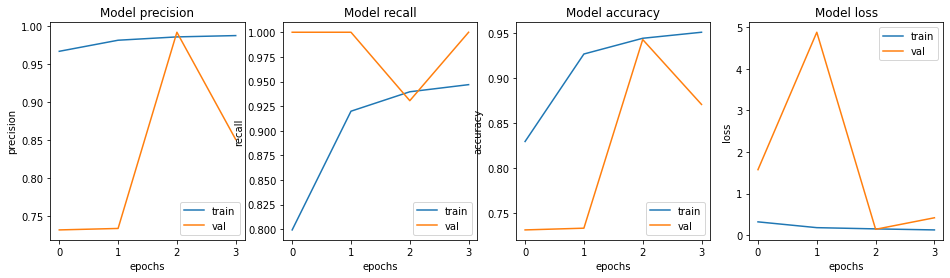

In [59]:
# result visualization (Dropout + Augmentation)
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_'+met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [60]:
loss, acc, prec, rec = model.evaluate(test_ds)
#Model Accuracy: 64.42%

39/39 [==============================] - 4s 112ms/step - loss: 3.5505 - accuracy: 0.6442 - precision: 0.6373 - recall: 1.0000


+ Batch Normalization만 진행하여, Epoch 수를 제한하면 Accuracy가 오를까?

**Batch Normalization (Epoch 6)**

In [62]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(), 
        #tf.keras.layers.Dropout(dropout_rate)   dropout 제거
    ])
    return block

In [63]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),    
        conv_block(128),
        conv_block(256),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [64]:
with tf.device('/GPU:0'):
    model = build_model()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS)

In [65]:
# training
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight
    )

Epoch 1/6
261/261 [==============================] - 58s 189ms/step - loss: 0.2337 - accuracy: 0.9114 - precision: 0.9740 - recall: 0.9051 - val_loss: 0.6683 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/6
261/261 [==============================] - 48s 186ms/step - loss: 0.1503 - accuracy: 0.9454 - precision: 0.9835 - recall: 0.9424 - val_loss: 1.3066 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/6
261/261 [==============================] - 48s 185ms/step - loss: 0.1238 - accuracy: 0.9538 - precision: 0.9867 - recall: 0.9508 - val_loss: 0.5709 - val_accuracy: 0.7635 - val_precision: 0.7560 - val_recall: 1.0000
Epoch 4/6
261/261 [==============================] - 49s 187ms/step - loss: 0.1131 - accuracy: 0.9579 - precision: 0.9883 - recall: 0.9545 - val_loss: 0.1838 - val_accuracy: 0.9394 - val_precision: 0.9986 - val_recall: 0.9186
Epoch 5/6
261/261 [==============================] - 49s 189ms/step - loss: 0.0963 - accuracy: 0

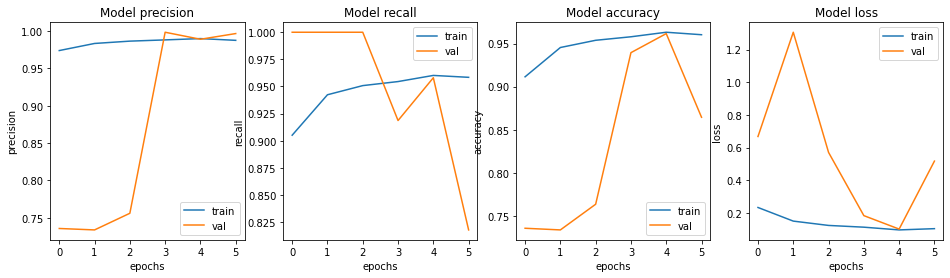

In [66]:
# result visualization (Batch Normalization)
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_'+met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [67]:
loss, acc, prec, rec = model.evaluate(test_ds)
# Model Accuracy: 86.70%

39/39 [==============================] - 4s 106ms/step - loss: 0.6073 - accuracy: 0.8670 - precision: 0.9205 - recall: 0.8615


## 4. Project Retrospective

+ 해외취업까지 염두하고 있어, 앞으로 모든 과제 제출을 영어로 진행할지 고민하고 있다.
+ EarlyStopping을 처음부터 적용했으면 더 빨리 마무리가 가능했을텐데 아쉽고, 평가하는 입장에서 더 쉽게 확인할 수 있도록 도표를 만들거나 그래프만 모아두는 등의 추가 액션이 있었다면 더 완성도가 높지 않았을까 싶다.
+ 최종 Model Accuracy는 86.70%를 달성했으나, 폐렴 환자의 경우 결국 Recall 값이 중요하므로 대체로 Epoch이 많았을 때에 Recall 값이 상위 수준(90% 이상)을 보였다는 점에서 더 많은 Epoch으로도 실험을 해보고 싶다.